PostgreSQL connection is closed
PostgreSQL connection is closed
caso_villarejo              0.507827
futbol                      0.224475
mayusculas                  0.111077
sentimiento                 0.098450
emoticonos_buenos           0.030384
lista_palabras_negativas    0.016308
lista_palabras_positivas    0.006376
emoticonos_malos            0.005103
dtype: float64



Random Forest
Score :0.8967527060782681





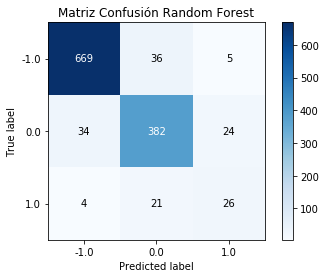

In [9]:
import psycopg2
import sys, nltk, re, string, heapq, gensim

from psycopg2 import Error
import math
from matplotlib import pyplot as plt
import pandas as pd
import pandas.io.sql as sqlio

import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import numpy as np

def crearConexion():
    
    connection = psycopg2.connect(user = "m.soto.montesinos",
                                      password = "1234",
                                      host = "127.0.0.1",
                                      port = "5432",
                                      database = "twitterBBVA")

    return connection

def obtenerTweets(tabla):

    try:
        
        connection = crearConexion()
        query = """
                SELECT clasificacion, sentimiento, caso_villarejo, futbol, mayusculas,
                lista_palabras_positivas, lista_palabras_negativas, emoticonos_buenos,
                emoticonos_malos FROM %s;
                """ % (tabla)
        
        tweets = sqlio.read_sql_query(query, connection)
        
    except (Exception, psycopg2.DatabaseError) as error :
    
        print ("Error obteniendo los datos", error)
    
    finally:
        
        if (connection):
            
            connection.close()
            print("PostgreSQL connection is closed")

    return tweets


def main():
    
    training_tweets = obtenerTweets("training_set")
    testing_tweets = obtenerTweets("testing_set")
    
    x_training_tweets = training_tweets.drop(columns = ['clasificacion'])
    y_training_tweets = training_tweets['clasificacion']
    x_testing_tweets = testing_tweets.drop(columns = ['clasificacion'])
    y_testing_tweets = testing_tweets['clasificacion']
    
    modelo_random_forest = RandomForestClassifier()
        
    #modelo_random_forest.fit(x_training_tweets, y_training_tweets)
    
    #feature_imp = pd.Series(modelo_random_forest.feature_importances_,index = x_training_tweets.columns).sort_values(ascending=False)
    #print(feature_imp)
    
    #score = modelo_random_forest.score(x_testing_tweets, y_testing_tweets)
    #predicciones = modelo_random_forest.predict(x_testing_tweets)
    
   
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap
                  }
    
    #Buscamos todas las combinaciones posibles
    rf_random = RandomizedSearchCV(estimator = modelo_random_forest, 
                                   param_distributions = random_grid, 
                                   n_iter = 100, 
                                   cv = 3, 
                                   verbose = 2, 
                                   random_state = 42, 
                                   n_jobs = -1)
    
    #Entrenamos el modelo con las posibles combinaciones.
    rf_random.fit(x_training_tweets, y_training_tweets)
    
    #Obtenemos los parametros con mejor resultado
    print(rf_random.best_params_)
    
    #{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 
    #'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
    
    modelo_random_forest = RandomForestClassifier(n_estimators = 400,
                                                 min_samples_split = 5,
                                                 min_samples_leaf = 1,
                                                 max_features = "sqrt",
                                                 max_depth = 30,
                                                 bootstrap = True)
        
    modelo_random_forest.fit(x_training_tweets, y_training_tweets)
    
    feature_imp = pd.Series(modelo_random_forest.feature_importances_,index = x_training_tweets.columns).sort_values(ascending=False)
    print(feature_imp)
    
    score = modelo_random_forest.score(x_testing_tweets, y_testing_tweets)
    predicciones = modelo_random_forest.predict(x_testing_tweets)
    
    print('\n\n')
    print("Random Forest")
    print("Score :" + str(score))
    print('\n\n')
    
    skplt.metrics.plot_confusion_matrix(y_testing_tweets,
                                        predicciones,
                                        title = "Matriz Confusión Random Forest",
                                        normalize=False)
    plt.show()
    
if __name__ == '__main__':
    main()






